In [230]:
import nltk
import torch
import emoji
import numpy as np
import pandas as pd
import torch.nn as nn
from torch.nn.functional import one_hot
from nltk.tokenize import word_tokenize
from torch.utils.data import random_split


# Loading Dataset

In [231]:
dataset=pd.read_csv('emoji_data.csv',header=None)

# Exploring Dataset

In [232]:
emoji_dict={
    0: ":red_heart:",
    1: ":baseball:",
    2: ":grinning_face_with_big_eyes:",
    3: ":disappointed_face:",
    4: ":fork_and_knife_with_plate:"
}

In [233]:
def emoji_label(label):
    if label<5:
     return emoji_dict[label]
    else:
        return "{label<5}"

In [234]:
dataset.iat[29,1]='0' #There was an error in the dataset, so I replaced it with 0

In [235]:
X=dataset[0]
Y=dataset[1]

# Embedding

In [236]:
#!pip install torchtext
import torchtext.vocab as vocab

The code below downloads 862 MB of data. This will be an embedded word with a vector length of 100. Please see the website for details.

In [237]:
glove = vocab.GloVe(name='6B', dim=100)
word_vectors = glove.vectors

In [238]:
file = open('.vector_cache\glove.6B.100d.txt', 'r', encoding = 'utf8')
content = file.readlines()
file.close()

The code parses the lines of text into a content variable, divides each line into words, and creates a dictionary containing the word's key and its corresponding numeric values ​​stored as a NumPy array, a vector that maps the words to be included. If the code is confusing to you, take the time to understand it

In [239]:
embedding={line.split()[0]:np.array(line.split()[1:] ,dtype=float) for line in content}

In [241]:
X_input = []
for quote in X:
    tokens = word_tokenize(quote.lower())
    embeddings = [torch.Tensor(embedding.get(w, torch.zeros(100))) for w in tokens]
    input_tensor = torch.stack(embeddings)
    X_input.append(input_tensor)

In [242]:
print("The maximum number of words in a sentence is {} and the minimum number of words in a sentence is {}".format(max([len(x) for x in X_input]),min([len(x) for x in X_input])))

The maximum number of words in a sentence is 10 and the minimum number of words in a sentence is 1


In [243]:
shape_input_zeros = (len(X_input), 10,100)

input_vector = np.zeros(shape_input_zeros, dtype='float32')

for i in range(len(X_input)): 
 input_vector[i][:len(X_input[i])]=X_input[i]

input_vector = np.array(input_vector)


In [245]:
for i in range(len(Y)):
 Y[i]=Y[i].replace(" ",'')
 Y[i]=int(Y[i])

# Model

In [247]:
input_size = 100 # Assuming 100-dimensional word embeddings
hidden_size = 128  # Set your desired hidden size
num_classes = 5  # The number of emoji classes
num_layers = 2  # Set your desired number of LSTM layers

class LstmModel(nn.Module):
    def __init__(self,input_size,hidden_size,num_class,num_layer):
        super(LstmModel,self).__init__()
        self.hidden_size=hidden_size
        self.num_layer=num_layer
        self.lstm=nn.LSTM(input_size,hidden_size,num_layer,batch_first=True)
        self.layer2=nn.Linear(num_classes,1)
        self.outlayer=nn.Linear(hidden_size,num_class)
    
    def forward(self,x):
       out, _=self.lstm(x)
       out = torch.mean(out, dim=1)
       out = self.outlayer(out)#[:, -1, :])  # Get the output from the last time step
       return out
    


lstmModel=LstmModel(input_size,hidden_size,num_classes,num_layers)

In [248]:
input_vector.dtype, input_vector[1].shape

(dtype('float32'), (10, 100))

# Data splitting and optim

In [249]:
# Define your loss function (criterion) and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lstmModel.parameters(), lr=0.001)

In [263]:
# Convert Xtrain and Y to PyTorch tensors
Xtrain = torch.tensor(input_vector, dtype=torch.float32)
Ytrain = torch.tensor(Y, dtype=torch.float32)

In [252]:
train_size=150
val_size=len(Xtrain)-train_size

In [253]:
#Creating Training and validating dataret
dataset = torch.utils.data.TensorDataset(Xtrain, Ytrain)
train_ds, val_ds = random_split(dataset, [train_size, val_size])

In [254]:
# Create data loaders for batch training
dataloader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_ds, batch_size=batch_size, shuffle=True)

## Training loop

In [251]:
# Define the number of epochs and batch size
num_epochs = 50
batch_size = 32

In [255]:
total_loss={'train_loss':[],'val_loss':[],'model':[]}
for i in range(num_epochs):
  for data in dataloader:
    x,y=data
    y = y.long()
    optimizer.zero_grad()

    result=lstmModel(x)
    loss = criterion(result, y)

      # Backpropagation and optimization
    loss.backward()
    optimizer.step()
  total_loss['train_loss'].append(loss.item())
  total_loss['model'].append(lstmModel)

#Validation
  for data in val_dataloader:
    x,y=data
    y = y.long()
    result=lstmModel(x)
    loss = criterion(result, y)
  total_loss['val_loss'].append(loss.item())

    


# Evaluating model

In [256]:
import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns

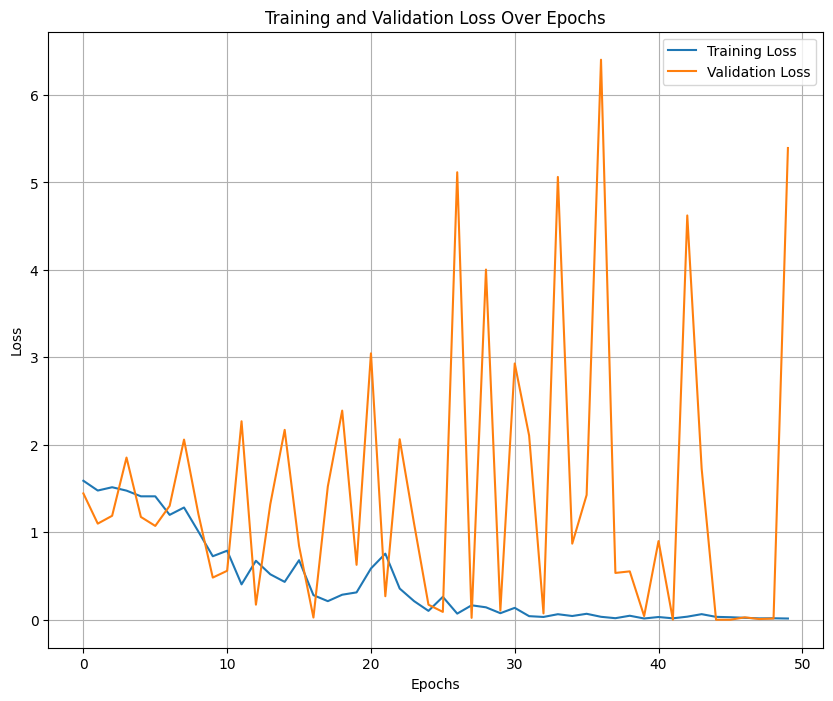

In [257]:
plt.figure(figsize=(10,8))
sns.lineplot(y=total_loss['train_loss'], x=range(len(total_loss['train_loss'])), label='Training Loss')

sns.lineplot(y=total_loss['val_loss'], x=range(len(total_loss['val_loss'])), label='Validation Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.grid(True)
plt.legend()

plt.show()

# Saving and loading model

In [258]:
lstmModel=total_loss['model'][34] #The chart above uses 34. In fact, the 34th model has the lowest validation loss.
torch.save(lstmModel.state_dict(),'Model.pth')

# model implementation

In [265]:
#loading model
load_model=LstmModel(input_size,hidden_size,num_classes,num_layers)
load_model.load_state_dict(torch.load('model.pth'))

<All keys matched successfully>

In [260]:
def emoji_pred(prompt):
 prompt_token=word_tokenize(prompt)

 prompt_embeddings = [torch.Tensor(embedding.get(w.lower(), torch.zeros(100))) for w in prompt_token]

 prompt_embeddings = torch.stack(prompt_embeddings)
 prompt_zeros = torch.zeros(10, 100)

 prompt_zeros[0:len(prompt_token)] = prompt_embeddings
 prompt_input = prompt_zeros

 prompt_pred=torch.max(load_model(prompt_input.unsqueeze(0)),dim=1) #Using loaded model

 prompt_pred=prompt_pred[1].item()


 return prompt_pred, emoji_dict[prompt_pred]


In [270]:
prompt='Machine learning'
print(emoji_pred(prompt))

(3, ':disappointed_face:')
